In [1]:
!pip install rasterio
!pip install fiona
!pip install shapely
!pip install geopandas
!pip install pycrs

     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/22.0 MB 1.8 MB/s eta 0:00:13
      --------------------------------------- 0.5/22.0 MB 3.6 MB/s eta 0:00:06
     -- ------------------------------------- 1.2/22.0 MB 7.8 MB/s eta 0:00:03
     --- ------------------------------------ 2.0/22.0 MB 9.8 MB/s eta 0:00:03
     ---- ----------------------------------- 2.5/22.0 MB 10.6 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 11.0 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB

In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib import ticker
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import re #used for making multiple string splits
import json
import os

from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
#load input file
# fp = r'cgls_landcover_2015_classification.tiff'
fp = r'cci_landcover_2010_v2.0.7cds.tif'
# fp = "dataPreprocessing/precipitationData/my_test_data.tif"
# fp = "dataPreprocessing/temperatureData/tiffTemperatureData/LST2012_avg.tiff"
data = rasterio.open(fp)



In [3]:
def show_land_cover(img):
    #labels for plotting
    labels = {0: {'color': '#282828', 'flag': 'unknown'},
              20: {'color': '#FFBB22', 'flag': 'shrubs'},
              30: {'color': '#FFFF4C', 'flag': 'herbaceous_vegetation'},
              40: {'color': '#F096FF', 'flag': 'cultivated_and_managed_vegetation_or_agriculture'},
              50: {'color': '#FA0000', 'flag': 'urban_or_built_up'},
              60: {'color': '#B4B4B4', 'flag': 'bare_or_sparse_vegetation'},
              70: {'color': '#F0F0F0', 'flag': 'snow_and_ice'},
              80: {'color': '#0032C8', 'flag': 'permanent_water_bodies'},
              90: {'color': '#0096A0', 'flag': 'herbaceous_wetland'},
              100: {'color': '#FAE6A0', 'flag': 'moss_and_lichen'},
              111: {'color': '#58481F', 'flag': 'closed_forest_evergreen_needle_leaf'},
              112: {'color': '#009900', 'flag': 'closed_forest_evergreen_broad_leaf'},
              113: {'color': '#70663E', 'flag': 'closed_forest_deciduous_needle_leaf'},
              114: {'color': '#00CC00', 'flag': 'closed_forest_deciduous_broad_leaf'},
              115: {'color': '#4E751F', 'flag': 'closed_forest_mixed'},
              116: {'color': '#007800', 'flag': 'closed_forest_not_matching_any_of_the_other_definitions'},
              121: {'color': '#666000', 'flag': 'open_forest_evergreen_needle_leaf'},
              122: {'color': '#8DB400', 'flag': 'open_forest_evergreen_broad_leaf'},
              123: {'color': '#8D7400', 'flag': 'open_forest_deciduous_needle_leaf'},
              124: {'color': '#A0DC00', 'flag': 'open_forest_deciduous_broad_leaf'},
              125: {'color': '#929900', 'flag': 'open_forest_mixed'},
              126: {'color': '#648C00', 'flag': 'open_forest_not_matching_any_of_the_other_definitions'},
              200: {'color': '#000080', 'flag': 'oceans_seas'}}
    #colors1 = [label['color'] for label in labels.values()]
    cmap = ListedColormap([label['color'] for label in labels.values()])
    norm = colors.BoundaryNorm(list(labels.keys())+[201], cmap.N+1, extend='max')
    ticks = list(np.mean((list(list(labels.keys())+[201])[i+1], val)) for i, val in enumerate(list(labels.keys())))
    cblabels=[label['flag'] for label in labels.values()]
    
    #file setup
    img_name, _ = img.split("_")
    img_name = img_name + ".tiff"
    # print(img_name)
    
    data = None
    with rasterio.open("landcover/"+img_name) as src:
        data = src.read()
        src.close() # close the rasterio dataset
    
#     data_array = np.array(data)
#     print(np.amin(data_array), np.amax(data_array))
# #     print(np.around(data_array, 1))
#     data_array = data_array[0,:,:]
#     arr = data_array
# #     arr = data_array * 0.02 - 273.15 #convert to celcius
#     print(np.around(arr, 1))
#     plt.imshow(arr)
#     plt.show()
        
#     src = rasterio.open("landcover/"+img_name)
#     data = src.read()
    
    fig, ax = plt.subplots()

    cb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=200.5), cmap=cmap), ax=ax)
    tick_locator = ticker.FixedLocator(locs=[(i*(200/23)+5) for i in range(len(ticks))])
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_ticklabels(cblabels[::-1])

    show(data, ax=ax, cmap=cmap, norm=norm) #transform=src.transform
    
    src.close()

In [4]:
#inspiration from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def generate_land_cover_image(satellite_image_name, input_file, view=0.01):
    out_name, coordinates = satellite_image_name.split("_")
    out_name = out_name + ".tiff"
    lat, lon = re.split(", |.png|,", coordinates)[:2]
    lat = float(lat)
    lon = float(lon)
    
    #finding the bounding box of the center coordinate
    up_rightX, up_rightY = round(lat-view,4), round(lon+view,4)
    down_leftX, down_leftY = round(lat+view,4), round(lon-view,4)
    bbox = box(up_rightX,up_rightY,down_leftX,down_leftY)
    # print("bbox", bbox)
    
    #Insert the BB to a GeoDataFrame and reproject it into the coordinate system of the input image
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs=data.crs.data)
    
    #Now we can receive the coordinates in the format that rasterio needs. 
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    #Clips the data with the defined polygon
    out_img, out_transform = mask(input_file, shapes=coords, all_touched=True, crop=True)
    
    #Updating the metadata
    out_meta = data.meta.copy()
    # print(out_meta)
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                   })
    
    #Writing the clipped image
    filepath = "./landcover/"+out_name
    if os.path.exists(filepath):
        os.remove(filepath) # delete the file 
    with rasterio.open(filepath, "w", **out_meta) as dest:
        dest.write(out_img)
        dest.close() # close the rasterio dataset
        

Manual testing

C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\3098715832.py:25: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


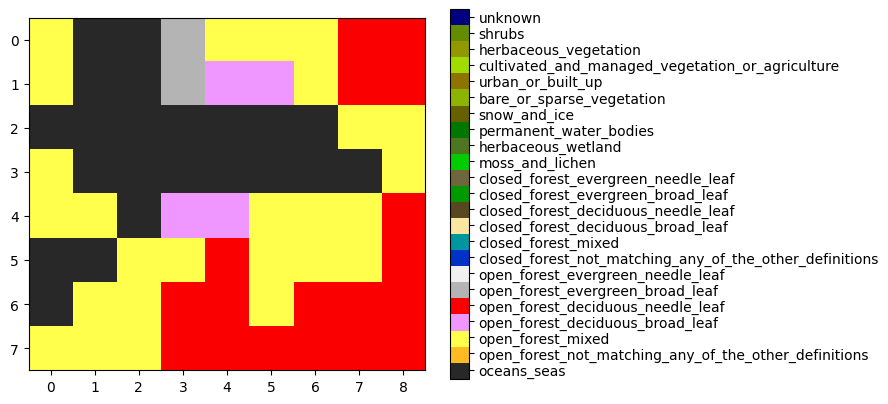

In [5]:
# file = "1_27.3348, -16.9727.png" 
# file = "2_27.3684, -17.479.png" 
# file = "100_27.2562, -16.7782.png"
file = "200_8.8124, 3.7315.png"  #Very good test by manual inspection, clearly on Malabo
# file = "210_31.379, 1.8387.png" # An ok test by manual inspection, we can see it is a bit northwest of lake victoria.


# print(np.amin(data), np.amax(data))


# generate_land_cover_image(satellite_image_name=file, input_file = data, view=2000) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=10) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=5) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=2) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=1) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.5) #6_28.7472, -16.504.png
# show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data, view=0.1) #6_28.7472, -16.504.png
# show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
show_land_cover(file)

In [15]:
import csv
import os

long_lat_year_path = "dataPreprocessing/malariaData/long_lat_year_with_confidential_from2010to18_size10orGreater.csv"
dataset_list = os.listdir('dataset')
# fp_first = r'cci_landcovers/cci_landcover_'
# fp_first = r'dataPreprocessing/temperatureData/tiffTemperatureData/LST'
fp_first = r'dataPreprocessing/precipitationData/tiffRainData/'

# fp_last = '_avg.tiff'
fp_last = 'rain_africa.tiff'

# Go through long_lat_year file instead of directory with images
with open(long_lat_year_path, encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        # print(row)
        id = row[0]
        print(id)
        if int(id) < 2900:
            continue
        long = row[1]
        lat = row[2]
        year = row[3]
        image_name = id+'_'+long + ", " + lat + ".png"
        fp = fp_first + year + fp_last
        data = rasterio.open(fp)
        generate_land_cover_image(satellite_image_name=image_name, input_file = data)


# dataset_list = os.listdir('dataset')
# for image in dataset_list:
#     if image == '.DS_Store':
#         continue
#     generate_land_cover_image(satellite_image_name=image, input_file = data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2902
2903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2907


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2909
2910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2915
2916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2918
2919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2920
2921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2922
2923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2924
2925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2926
2927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2928
2929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2935
2936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2937
2938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2939
2940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2941
2942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2943
2944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2945
2946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2947
2948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2950
2951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2959
2960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2961
2962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2965
2966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2974
2975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2979
2980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2982
2983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2994
2995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

2996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2998
2999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3002
3003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3004
3005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3008
3009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3023
3024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3026
3027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3033


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3039
3040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3064
3065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3071
3072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3084
3085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3091
3092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3098
3099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3129
3130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3149
3150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3160
3161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3168
3169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3171
3172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3175
3176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3182
3183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3186
3187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3188
3189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3192
3193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3194
3195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3196
3197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3198
3199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3200
3201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3202
3203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3204
3205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3207
3208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3213
3214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3215
3216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3217
3218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3219
3220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3221
3222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3223
3224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3230
3231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3243
3244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3245
3246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3247
3248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3249
3250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3251
3252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3253
3254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3267
3268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3277
3278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3280
3281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3282
3283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3284
3285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3286
3287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3288
3289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3290
3291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3300
3301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3306
3307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3319
3320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3327
3328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3337
3338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3339
3340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3347
3348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3356
3357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3363
3364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3393
3394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3396
3397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3402
3403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3411
3412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3425
3426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3428
3429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3446
3447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3450
3451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3462
3463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3464
3465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3466
3467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3468
3469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3470
3471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3472
3473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3474
3475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3476
3477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3481
3482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3484
3485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3495
3496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3497
3498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3504
3505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3508
3509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3510
3511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3518
3519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3528
3529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3565
3566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3572
3573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3584
3585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3589
3590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3607
3608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3613
3614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3616
3617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3636
3637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3646
3647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3649
3650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3665
3666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3676
3677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3679
3680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3701
3702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3709
3710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3711
3712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3722
3723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3724
3725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3753
3754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3766
3767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3768
3769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3770
3771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3772
3773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3774
3775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3776
3777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3787


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3804
3805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3808
3809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3810


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3815
3816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3828
3829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3831


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3834
3835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3840
3841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3843
3844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3851
3852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3859
3860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3880
3881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3894
3895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3904
3905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3907


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3909


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3915
3916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3927
3928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3943
3944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3949
3950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3955
3956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3959


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3961
3962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3965
3966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3972
3973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3974
3975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3976
3977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3978
3979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3980
3981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3982
3983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3984
3985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3986
3987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3988
3989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

3990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


3999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4009
4010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4029
4030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4033
4034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4037
4038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4039
4040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4059
4060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4069
4070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4074
4075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4101
4102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4106
4107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4122
4123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4126
4127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4137
4138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4140
4141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4143
4144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4158
4159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4170
4171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4172
4173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4174
4175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4176
4177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4178
4179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4180
4181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4182
4183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4190
4191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4192
4193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4194
4195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4196
4197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4198
4199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4200
4201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4203
4204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4205
4206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4218
4219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4236


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4250
4251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4264
4265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4272
4273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4274
4275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4276
4277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4278
4279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4280
4281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4282
4283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4284
4285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4307
4308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4331
4332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4355
4356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4381
4382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4383
4384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4387
4388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4403
4404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4415
4416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4419
4420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4421
4422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4426
4427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4435
4436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4441
4442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4444
4445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4446
4447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4459
4460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4465
4466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4484
4485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4496
4497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4510
4511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4512
4513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4517
4518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4519
4520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4521
4522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4523
4524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4525
4526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4527
4528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4533
4534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4535
4536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4537
4538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4539
4540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4541
4542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4543
4544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4545
4546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4548
4549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4550
4551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4555
4556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4557
4558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4559
4560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4561
4562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4564
4565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4566
4567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4572
4573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4579
4580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4610
4611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4612
4613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4614
4615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4616
4617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4618
4619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4620
4621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4623
4624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4637
4638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4641
4642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4654
4655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4656
4657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4658
4659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4660
4661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4662
4663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4664
4665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4666
4667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4674
4675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4676
4677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4678
4679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4680
4681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4682
4683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4684
4685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4692
4693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4694
4695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4696
4697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4699
4700


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4702
4703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4704


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4705
4706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4707
4708


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4709
4710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4711
4712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4713
4714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4715
4716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4727
4728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4733
4734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4737
4738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4739
4740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4741
4742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4743
4744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4745
4746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4747
4748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4749
4750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4755
4756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4758
4759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4760
4761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4762
4763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4764
4765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4766
4767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4768
4769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4771
4772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4773
4774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4781
4782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4787


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4794
4795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4803
4804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4805
4806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4810


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4816
4817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4831


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4844
4845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4847
4848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4849
4850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4852
4853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4854
4855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4856
4857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4858
4859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4860
4861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4862
4863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4869
4870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4871
4872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4873
4874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4875
4876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4877
4878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4879
4880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4881
4882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4891
4892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4897
4898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4903
4904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4907


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4909


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4911
4912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4917
4918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4925
4926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4931
4932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4938
4939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4941
4942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4954
4955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4959
4960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4976
4977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4982


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4984
4985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4993
4994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4996
4997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

4998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


4999
5000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5001
5002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5009
5010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5011
5012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5013
5014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5015
5016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5017
5018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5019
5020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5021
5022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5033


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5047
5048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5056
5057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5063
5064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5067
5068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5074
5075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5076
5077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5078
5079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5080
5081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5082
5083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5084
5085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5089
5090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5093
5094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5095
5096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5097
5098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5099
5100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5101
5102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5103
5104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5109
5110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5112
5113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5114
5115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5116
5117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5118
5119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5120
5121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5122
5123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5126
5127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5130
5131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5132
5133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5134
5135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5136
5137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5138
5139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5140
5141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5142
5143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5147
5148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5149
5150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5151
5152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5153
5154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5155
5156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5157
5158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5159
5160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5161
5162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5173
5174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5175
5176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5177
5178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5179
5180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5181
5182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5183
5184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5185
5186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5187
5188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5189
5190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5191
5192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5193
5194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5195
5196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5197
5198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5199
5200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5201
5202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5203
5204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5205
5206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5207
5208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5209
5210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5211
5212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5213
5214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5215
5216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5217
5218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5219
5220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5226
5227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5228
5229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5230
5231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5232
5233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5234
5235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5236
5237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5244
5245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5246
5247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5248
5249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5250
5251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5252
5253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5254
5255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5256
5257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5261
5262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5264
5265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5266
5267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5268
5269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5270
5271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5272
5273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5274
5275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5279
5280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5284
5285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5286
5287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5288
5289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5290
5291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5292
5293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5294
5295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5297
5298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5303
5304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5305
5306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5307
5308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5309
5310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5311
5312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5313
5314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5321
5322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5323
5324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5325
5326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5327
5328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5329
5330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5331
5332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5339
5340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5341
5342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5343
5344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5345
5346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5347
5348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5349
5350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5351
5352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5357
5358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5359
5360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5361
5362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5363
5364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5365
5366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5367
5368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5369
5370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5377
5378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5379
5380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5381
5382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5383
5384


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5385
5386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5387
5388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5391
5392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5409
5410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5424
5425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5442


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5448
5449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5454
5455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5458
5459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5462
5463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5465
5466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5468
5469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5473
5474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5475
5476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5489
5490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5492
5493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5505
5506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5515
5516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5531
5532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5550
5551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5559
5560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5576
5577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5586
5587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5592
5593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5595
5596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5612


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5641
5642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5653
5654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5665
5666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5698
5699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5700
5701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5702


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5704
5705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5706


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5708
5709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5715
5716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5718
5719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5737
5738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5743
5744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5760
5761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5764
5765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5771
5772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5774
5775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5777
5778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5787
5788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5791
5792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5794
5795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5806
5807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5808
5809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5810
5811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5812
5813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5822
5823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5831
5832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5833
5834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5835
5836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5837
5838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5839
5840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5841
5842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5843
5844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5854
5855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5863
5864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5868
5869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5877
5878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5891
5892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5894
5895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5901
5902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5907
5908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5909
5910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5911
5912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5913
5914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5915
5916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5917
5918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5919
5920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5928
5929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5931
5932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5959


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5961
5962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5964
5965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5982


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5986
5987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


5995
5996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5997
5998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

5999
6000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6001
6002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6003
6004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6005
6006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6009
6010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6014
6015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6016
6017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6018
6019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6020
6021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6022
6023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6024
6025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6026
6027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6033
6034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6035
6036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6037
6038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6039
6040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6041
6042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6043
6044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6050
6051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6052
6053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6054
6055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6056
6057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6058
6059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6060
6061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6062
6063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6069
6070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6071
6072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6073
6074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6075
6076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6077
6078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6079
6080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6081
6082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6084
6085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6087
6088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6090
6091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6092
6093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6094
6095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6096
6097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6098
6099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6100
6101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6115
6116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6117
6118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6121
6122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6124
6125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6128
6129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6130
6131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6132
6133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6134
6135


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6136
6137


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6138
6139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6147
6148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6149
6150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6151
6152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6153
6154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6155
6156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6157
6158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6161
6162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6171
6172


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6179
6180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6181
6182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6183
6184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6185
6186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6187
6188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6189
6190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6191
6192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6209
6210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6212
6213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6224
6225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6232


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6234


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6236
6237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6241
6242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6249
6250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6264
6265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6268


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6279
6280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6281
6282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6283
6284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6285
6286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6287
6288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6289
6290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6291
6292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6293
6294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6295
6296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6297
6298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6299
6300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6301
6302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6303
6304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6305
6306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6307
6308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6309
6310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6311
6312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6313
6314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6315
6316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6317
6318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6319
6320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6336
6337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6348
6349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6357
6358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6359
6360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6365
6366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6371
6372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6378
6379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6381
6382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6384
6385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6388


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6395
6396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6406
6407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6419
6420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6421
6422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6424
6425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6426
6427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6432
6433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6434
6435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6436
6437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6438
6439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6440
6441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6442
6443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6444
6445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6458
6459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6469


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6478
6479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6490
6491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6497
6498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6499
6500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6507
6508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6517
6518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6530
6531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6532
6533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6548
6549


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6550
6551


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6553


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6563
6564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6565
6566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6567
6568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6569
6570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6571
6572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6573
6574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6575
6576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6579
6580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6584
6585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6586
6587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6588
6589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6590
6591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6592
6593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6594
6595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6596
6597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6612
6613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6634
6635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6658
6659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6668
6669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6670
6671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6677


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6684
6685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6686
6687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6690
6691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6696
6697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6698
6699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6700
6701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6702
6703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6704
6705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6706
6707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6708
6709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6710


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6716
6717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6748
6749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6750
6751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6754
6755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6756
6757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6758
6759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6760
6761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6762
6763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6764
6765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6766
6767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6771


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6773
6774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6775
6776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6777
6778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6779
6780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6781
6782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6783
6784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6785
6786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6787


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6791
6792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6793
6794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6795
6796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6797
6798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6799
6800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6801
6802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6803
6804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6807
6808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6810


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6814
6815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6817
6818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6819
6820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6824
6825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6827
6828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6829
6830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6831
6832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6833
6834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6835
6836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6837
6838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6846


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6848


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6853
6854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6856


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6859
6860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6861
6862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6863
6864


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6865
6866


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6867
6868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6869
6870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6872
6873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6879
6880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6881
6882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6883
6884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6885
6886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6887
6888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6889
6890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6895
6896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6898
6899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6900
6901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6902
6903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6904
6905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6906
6907


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6908
6909


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6910
6911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6913
6914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6917
6918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6919
6920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6921
6922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6923
6924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6925
6926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6927
6928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6930
6931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6936
6937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6938
6939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6940
6941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6942
6943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6944
6945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6946
6947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6955


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6959


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6960
6961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6963


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6971
6972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6979


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6982
6983


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6986
6987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

6988


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6990


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6992


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6994


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6996


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


6998
6999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7007
7008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7011


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7012
7013


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7033
7034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7038
7039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7055
7056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7059
7060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7063
7064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7092
7093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7103
7104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7108
7109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7111
7112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7113
7114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7116
7117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7118
7119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7121
7122


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7123
7124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7125
7126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7127
7128


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7135
7136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7137
7138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7139


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7141


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7172
7173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7180
7181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7183
7184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7203
7204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7210


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7216
7217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7225
7226


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7227
7228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7229
7230


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7232
7233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7234
7235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7236
7237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7240


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7243
7244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7245
7246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7247
7248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7251
7252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7253


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7256
7257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7258
7259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7260
7261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7262
7263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7264
7265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7266
7267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7268
7269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7270


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7275
7276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7277
7278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7279
7280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7281
7282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7283
7284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7285
7286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7290
7291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7294
7295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7296
7297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7298
7299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7300
7301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7302
7303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7304
7305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7306
7307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7313
7314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7315
7316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7317
7318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7319
7320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7321
7322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7323
7324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7330
7331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7332
7333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7334
7335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7336
7337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7338
7339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7340
7341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7344
7345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7348
7349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7350
7351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7352
7353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7354
7355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7356
7357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7358
7359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7373
7374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7380


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7384
7385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7386
7387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7388
7389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7390
7391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7392
7393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7394
7395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7407


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7413


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7421


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7423


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7425


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7427


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7429


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7430
7431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7437
7438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7440


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7442
7443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7444


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7446


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7452


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7457
7458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7459
7460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7469
7470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7477


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7479


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7483
7484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7494
7495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7499


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7507


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7517
7518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7525
7526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7531
7532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7533
7534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7536
7537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7538
7539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7549
7550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7551
7552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7553
7554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7555


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7559


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7563


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7565
7566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7575
7576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7577
7578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7579
7580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7581
7582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7583
7584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7585
7586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7593
7594


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7595
7596


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7597
7598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7599
7600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7601
7602


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7603
7604


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7610


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7612
7613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7614
7615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7616
7617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7618
7619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7620
7621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7622
7623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7625


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7629


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7631


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7634
7635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7637


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7643
7644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7649
7650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7661
7662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7667
7668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7669
7670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7671
7672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7673
7674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7675
7676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7677
7678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7679
7680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7694


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7698
7699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7700
7701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7702
7703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7704
7705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7706
7707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7708
7709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7710
7711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7712


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7713
7714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7715
7716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7720
7721


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7722
7723


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7724
7725


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7726
7727


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7728
7729


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7730
7731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7737


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7739


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7741


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7743


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7745


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7746
7747


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7749


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7750
7751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7752
7753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7754
7755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7756
7757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7758
7759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7760
7761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7762
7763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7769
7770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7771
7772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7773
7774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7775
7776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7777
7778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7779
7780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7781
7782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7783
7784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7785
7786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7787


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7788


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7799
7800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7802
7803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7804
7805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7806
7807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7808
7809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7810
7811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7812
7813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7814
7815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7821


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7827


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7829


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7831


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7834


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7836


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7838


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7840


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7842


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7844


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7846
7847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7848
7849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7850
7851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7852
7853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7854
7855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7856
7857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7858


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7860


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7862


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7864
7865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7866
7867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7868
7869


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7870
7871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7872
7873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7874
7875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7881


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7884


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7885
7886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7887
7888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7890


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7892


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7894


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7896


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7898


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7900


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7901
7902


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7907


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7909
7910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7911


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7913


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7915


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7917


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7919


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7921


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7934


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7938


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7939
7940


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7941
7942


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7944


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7946


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7948


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7950


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7952


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7953
7954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7955
7956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7957
7958


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7959
7960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7961
7962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7963
7964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7966
7967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7969
7970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7971


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7973
7974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7975
7976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7977
7978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7979
7980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7981
7982


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7983
7984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7985


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7986


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


7988
7989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7990
7991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7992
7993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7994
7995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7996
7997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

7998
7999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8000
8001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8006
8007


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8009
8010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8011
8012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8013
8014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8015
8016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8017
8018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8019
8020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8027
8028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8029
8030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8031
8032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8033
8034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8035
8036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8037
8038


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8045
8046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8047
8048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8049
8050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8051
8052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8053
8054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8055
8056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8059


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8061


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8063


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8064
8065


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8066
8067


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8068
8069


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8070
8071


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8072
8073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8074
8075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8080


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8083
8084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8085
8086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8087
8088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8089
8090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8091
8092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8093
8094


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8100


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8101
8102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8103
8104


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8105
8106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8107
8108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8109
8110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8111
8112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8118
8119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8120
8121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8122
8123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8124
8125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8126
8127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8128
8129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8131


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8133


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8135
8136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8137
8138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8139
8140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8141
8142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8143
8144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8145
8146


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8147
8148


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8151


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8153


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8155


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8157


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8159


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8161


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8165


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8167
8168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8169


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8170
8171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8172
8173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8174


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8175
8176


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8177
8178


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8179
8180


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8181
8182


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8183
8184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8185
8186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8196
8197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8199
8200


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8210
8211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8217
8218


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8220
8221


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8222
8223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8224
8225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8226
8227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8228
8229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8230
8231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8232
8233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8234
8235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8236
8237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8238


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8240
8241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8242
8243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8244
8245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8246
8247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8248
8249


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8250
8251


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8253
8254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8255


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8257


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8259


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8260
8261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8262
8263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8264
8265


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8266
8267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8268
8269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8270
8271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8272


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8274


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8276


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8278


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8280


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8283


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8286


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8288


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8290


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8292


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8293
8294


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8296


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8298


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8300


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8301
8302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8308


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8313
8314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8317
8318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8320


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8322


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8324


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8326


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8328


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8330


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8335
8336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8337


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8339
8340


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8344
8345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8352
8353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8354
8355


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8357
8358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8359
8360


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8368
8369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8370
8371


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8376


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8378
8379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8380
8381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8382
8383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8384
8385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8386
8387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8388
8389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8401


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8403


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8405


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8407
8408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8409


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8411


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8413
8414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8415


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8417


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8419


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8421
8422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8423
8424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8425
8426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8427
8428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8429
8430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8431
8432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8433


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8434
8435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8436


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8438


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8440
8441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8442
8443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8444
8445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8446
8447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8448
8449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8450
8451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8452
8453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8454


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8455
8456


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8458


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8459
8460


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8461
8462


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8463
8464


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8465
8466


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8467
8468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8469
8470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8472


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8475


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8477
8478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8479
8480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8481


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8483


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8485


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8490
8491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8492
8493


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8494
8495


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8496
8497


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8499
8500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8501


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8503


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8505
8506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8507
8508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8509
8510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8511
8512


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8513
8514


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8515
8516


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8517
8518


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8520


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8522


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8524
8525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8526
8527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8528
8529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8530
8531


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8532
8533


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8534
8535


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8536
8537


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8539


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8540
8541


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8543
8544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8545
8546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8547
8548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8549
8550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8551
8552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8553
8554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8555
8556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8557


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8559
8560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8561
8562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8563
8564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8565
8566


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8567
8568


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8569
8570


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8571
8572


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8573
8574


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8575
8576


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8578


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8580


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8581
8582


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8583
8584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8585
8586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8587
8588


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8589
8590


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8591
8592


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8594
8595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8596
8597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8598


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8599
8600


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8602
8603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8604
8605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8606
8607


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8608
8609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8610
8611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8612
8613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8614


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8616


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8618


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8619
8620


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8621
8622


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8623
8624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8625
8626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8627
8628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8629
8630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8631
8632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8633


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8635


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8637
8638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8639


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8640
8641


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8642
8643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8644
8645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8646
8647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8648
8649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8650
8651


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8654
8655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8659
8660


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8661
8662


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8663
8664


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8665
8666


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8667
8668


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8669
8670


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8671
8672


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8677
8678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8679
8680


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8681
8682


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8683
8684


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8685
8686


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8687
8688


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8690


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8694
8695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8696
8697


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8698
8699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8700
8701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8702
8703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8704
8705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8706
8707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8708
8709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8710
8711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8712
8713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8716


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8717
8718


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8719
8720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8721
8722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8723
8724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8725
8726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8727
8728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8729
8730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8732


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8737
8738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8739
8740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8741
8742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8743
8744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8745
8746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8747
8748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8749
8750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8751


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8752
8753


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8755


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8756
8757


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8758
8759


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8760
8761


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8762
8763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8764
8765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8766
8767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8768
8769


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8771
8772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8773


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8775


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8776
8777


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8778
8779


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8780
8781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8782
8783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8784
8785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8786
8787


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8788
8789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8790


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8791
8792


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8794


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8795
8796


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8797
8798


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8799
8800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8801
8802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8803
8804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8805
8806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8807
8808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8810


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8813
8814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8817
8818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8819
8820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8821
8822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8823
8824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8825
8826


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8827
8828


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8829
8830


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8831
8832


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8833


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8834
8835


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8836
8837


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8838
8839


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8840
8841


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8842
8843


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8844
8845


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8846
8847


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8848
8849


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8850


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8851


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8852


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8853


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8854


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8855


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8856
8857


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8858
8859


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8860
8861


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8862
8863


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8864
8865


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8866
8867


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8868


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8869
8870


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8871


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8872


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8873


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8874


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8875


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8876


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8877


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8878


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8879


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8880


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8881
8882


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8883


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8884
8885


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8886


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8887


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8888


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8889


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8890
8891


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8892
8893


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8894
8895


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8896
8897


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8898
8899


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8900
8901


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8902
8903


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8904


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8905


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8906


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8907
8908


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8909
8910


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8911
8912


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8913
8914


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8915
8916


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8917
8918


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8919
8920


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8921
8922


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8923


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8924


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8925


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8926


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8927


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8928


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8929


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8930


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8931


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8932


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8933


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8934
8935


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8936


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8937


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8938
8939


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8940
8941


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8942
8943


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8944
8945


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8946
8947


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8948
8949


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8950
8951


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8952
8953


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8954


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8955
8956


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8957


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8958
8959


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8960


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8961


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8962


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8963
8964


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8965


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8966


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8967


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8968


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8969


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8970


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8971
8972


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8973


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8974


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8975


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8976


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8977


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8978


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8979
8980


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8981


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8982


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8983
8984


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8985
8986
8987


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8988
8989


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8990
8991


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8992
8993


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8994
8995


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8996
8997


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

8998


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8999


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9000


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9001


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9002


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9003


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9004


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9005


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9006


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9007
9008


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9009


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9010


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9011
9012


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9013
9014


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9015


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9016


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9017


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9018


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9019


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9020


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9021


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9022


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9023


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9024


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9025


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9026


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9027


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9028


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9029


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9030


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9031


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9032


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9033
9034


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9035


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9036


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9037


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9038
9039


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9040


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9041


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9042


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9043


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9044


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9045


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9046


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9047


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9048


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9049


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9050


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9051


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9052


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9053


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9054


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9055


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9056


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9057


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9058


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9059
9060


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9061
9062


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9063
9064


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9065
9066


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9067
9068


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9069
9070


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9071
9072


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9073


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9074


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9075


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9076


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9077


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9078


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9079


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9080
9081


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9082


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9083


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9084


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9085


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9086


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9087


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9088


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9089


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9090


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9091


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9092


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9093


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9094
9095


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9096


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9097


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9098


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9099


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9100
9101


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9102


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9103


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9104
9105


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9106


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9107


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9108


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9109


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9110


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9111


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9112


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9113


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9114


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9115


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9116


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9117


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9118


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9119


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9120


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9121


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9122
9123


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9124


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9125


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9126


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9127


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9128
9129


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9130


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9131
9132


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9133
9134


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9135
9136


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9137
9138


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9139
9140


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9141
9142


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9143


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9144


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9145


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9146
9147


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9148
9149


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9150


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9151
9152


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9153
9154


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9155
9156


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9157
9158


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9159
9160


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9161
9162


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9163


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9164


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9165
9166


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9167


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9168


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9169
9170


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9171


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9172
9173


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9174
9175


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9176
9177


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9178
9179


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9180
9181


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9182
9183


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9184


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9185


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9186


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9187


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9188


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9189


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9190


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9191


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9192


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9193


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9194


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9195


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9196


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9197


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9198


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9199


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9200
9201


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9202


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9203


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9204


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9205


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9206


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9207


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9208


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9209


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9210
9211


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9212


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9213


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9214


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9215


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9216


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9217


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9218
9219


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9220


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9221
9222


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9223


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9224


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9225


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9226
9227


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9228


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9229


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9230
9231


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9232
9233


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9234
9235


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9236
9237


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9238
9239


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9240
9241


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9242


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9243


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9244


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9245


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9246


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9247


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9248


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9249
9250


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9251
9252


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9253
9254


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9255
9256


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9257
9258


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9259
9260


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9261


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9262


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9263


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9264


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9265
9266


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9267


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9268
9269


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9270
9271


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9272
9273


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9274
9275


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9276
9277


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9278
9279


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9280
9281


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9282


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9283
9284


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9285


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9286
9287


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9288
9289


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9290
9291


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9292
9293


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9294
9295


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9296
9297


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9298
9299


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9300
9301


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9302


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9303


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9304


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9305


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9306


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9307


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9308
9309


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9310


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9311


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9312


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9313


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9314


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9315


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9316


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9317


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9318


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9319


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9320
9321


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9322
9323


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9324
9325


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9326
9327


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9328
9329


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9330
9331


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9332


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9333


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9334


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9335


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9336


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9337
9338


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9339


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9340
9341


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9342


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9343


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9344


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9345


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9346


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9347


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9348


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9349


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9350


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9351


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9352


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9353


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9354


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9355
9356


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9357


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9358


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9359


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9360
9361


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9362


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9363


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9364


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9365


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9366


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9367


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9368


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9369


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9370


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9371
9372


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9373


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9374


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9375


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9376
9377


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9378


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9379


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9380
9381


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9382


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9383


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9384
9385


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9386


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9387


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9388
9389


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9390


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9391


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9392


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9393


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9394


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9395


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9396


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9397


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9398


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9399


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9400


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9401
9402


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9403
9404


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9405
9406


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9407
9408


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9409
9410


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9411
9412


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9413
9414


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9415
9416


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9417
9418


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9419
9420


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9421
9422


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9423
9424


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9425
9426


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9427
9428


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9429
9430


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9431


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9432


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9433
9434


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9435


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9436
9437


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9438
9439


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9440
9441


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9442
9443


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9444
9445


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9446
9447


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9448


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9449


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9450


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9451


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9452
9453


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9454
9455


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9456
9457


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9458
9459


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9460
9461


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9462
9463


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9464
9465


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9466
9467


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9468


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9469
9470


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9471


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9472
9473


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9474


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9475
9476


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9477
9478


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9479
9480


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9481
9482


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9483
9484


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9485
9486


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9487


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9488


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9489


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9490


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9491


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9492


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9493
9494


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9495
9496


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9497
9498


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9499
9500


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9501
9502


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9503
9504


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9505


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9506


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9507
9508


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9509


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9510


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9511


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9512
9513


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9514
9515


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9516
9517


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9518
9519


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9520
9521


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9522
9523


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9524


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9525


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9526


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9527


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9528


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9529


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9530


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9531
9532


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9533
9534


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9535
9536


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9537
9538


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9539
9540


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9541
9542


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9543


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9544


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9545


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9546


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9547


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9548


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9549
9550


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9551
9552


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9553
9554


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9555
9556


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9557
9558


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9559
9560


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9561


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9562


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9563
9564


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9565


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9566
9567


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9568
9569


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9570
9571


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9572
9573


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9574
9575


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9576
9577


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9578
9579


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9580
9581


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9582
9583


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9584


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9585


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9586


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9587


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9588
9589


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9590
9591


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9592
9593


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9594
9595


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9596
9597


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9598
9599


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9600
9601


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9602
9603


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9604
9605


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9606


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9607
9608


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9609


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9610
9611


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9612
9613


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9614
9615


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9616
9617


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9618
9619


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9620
9621


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9622
9623


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9624


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9625
9626


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9627


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9628


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9629
9630


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9631
9632


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9633
9634


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9635
9636


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9637
9638


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9639
9640


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9641
9642


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9643


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9644


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9645


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9646


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9647


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9648


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9649


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9650


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9651
9652


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9653


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9654


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9655


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9656


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9657


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9658


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9659


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9660
9661


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9662
9663


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9664
9665


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9666
9667


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9668
9669


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9670
9671


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9672
9673


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9674


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9675


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9676


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9677
9678


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9679


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9680
9681


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9682
9683


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9684
9685


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9686
9687


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9688
9689


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9690
9691


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9692


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9693


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9694
9695


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9696


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9697
9698


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9699


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9700
9701


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9702
9703


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9704
9705


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9706
9707


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9708
9709


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9710
9711


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9712
9713


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9714


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9715


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9716
9717


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9718
9719


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9720


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9721
9722


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9723
9724


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9725
9726


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9727
9728


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9729
9730


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9731


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9732
9733


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9734


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9735


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9736


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9737
9738


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9739
9740


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9741
9742


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9743
9744


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9745
9746


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9747
9748


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9749
9750


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9751
9752


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9753
9754


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9755
9756


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9757
9758


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9759
9760


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9761
9762


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9763


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9764


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9765


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9766


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9767


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9768


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9769
9770


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9771
9772


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9773
9774


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9775
9776


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9777
9778


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9779
9780


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9781


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9782


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9783


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9784


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9785


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9786


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9787


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9788
9789


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9790
9791


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9792
9793


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9794
9795


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9796
9797


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9798
9799


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9800


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9801


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9802


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9803


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9804


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9805


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9806


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9807


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9808


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9809


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9810


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9811


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9812


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9813


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9814


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9815


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9816


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9817


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9818


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9819


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9820


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9821
9822


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\ve

9823


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9824


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


9825


C:\Users\r-kli\AppData\Local\Temp\ipykernel_13600\1523850158.py:28: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=image_name, input_file = data)
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
#Test
from PIL import Image
for i in range(263):

    im = Image.open('landcover/' + str(i+1) + '.tiff')
    imarray = np.array(im)
#     if imarray.shape[0] > 10:
#         print(i+1)
#         continue
    print(i+1, imarray)
cci_landcovers/cci_landcover_2010_v2.0.7cds.tif